In [141]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import random
from sklearn.metrics import precision_score, recall_score, f1_score

import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [142]:
def clear_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [143]:
# Hyperparameters
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
NORMAL_DATACOUNT = 400
ANORMALY_DATACOUNT = 400
TOTAL_DATACOUNT = NORMAL_DATACOUNT + ANORMALY_DATACOUNT

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [145]:
normal_data = np.random.randn(NORMAL_DATACOUNT, 21, 21)
normal_test_data = np.random.randn(NORMAL_DATACOUNT, 21, 21)
anomaly_data = np.random.randn(ANORMALY_DATACOUNT, 21, 21)
anomaly_test_data = np.random.randn(ANORMALY_DATACOUNT, 21, 21)
gradcam_data = np.zeros((TOTAL_DATACOUNT, 21, 21))
gradcam_test_data = np.zeros((TOTAL_DATACOUNT, 21, 21))

In [146]:
print(normal_data.shape, normal_test_data.shape)
print(anomaly_data.shape, anomaly_test_data.shape)
print(gradcam_data.shape, gradcam_test_data.shape)

(400, 21, 21) (400, 21, 21)
(400, 21, 21) (400, 21, 21)
(800, 21, 21) (800, 21, 21)


In [147]:
def min_max_normalize(array, is_tensor=True):
    eps = np.finfo(float).eps  # 아주 작은 값

    if is_tensor:
        if array.dim() == 3:  # (1000, 21, 21)
            min_val = torch.amin(array, dim=(1, 2), keepdim=True)
            max_val = torch.amax(array, dim=(1, 2), keepdim=True)
        elif array.dim() == 4:  # (batch, channels, height, width)
            min_val = torch.amin(array, dim=(2, 3), keepdim=True)
            max_val = torch.amax(array, dim=(2, 3), keepdim=True)
        else:
            raise ValueError("Unexpected tensor shape. Expected a 3D or 4D tensor.")
        
        normalized_array = (array - min_val) / (max_val - min_val + eps)
    else:
        if array.ndim == 3:  # (1000, 21, 21)
            min_val = np.min(array, axis=(1, 2), keepdims=True)
            max_val = np.max(array, axis=(1, 2), keepdims=True)
        elif array.ndim == 4:  # (batch, channels, height, width)
            min_val = np.min(array, axis=(2, 3), keepdims=True)
            max_val = np.max(array, axis=(2, 3), keepdims=True)
        else:
            raise ValueError("Unexpected array shape. Expected a 3D or 4D array.")
        
        normalized_array = (array - min_val) / (max_val - min_val + eps)
        
    return normalized_array

In [148]:
def plot_data(data, title):
    plt.imshow(data)
    plt.title(title)
    plt.colorbar()
    plt.show()

def make_point(data, index, weight):
    position = []
    for k, d in enumerate(data):
        temp = []
        for idx, w in zip(index[k], weight[k]):
            i = idx//3 * 5 + 5
            j = idx%3 * 5 + 5
            d[i, j] = w * 100
            temp.append((i, j))
        position.append(temp)
    
    data = min_max_normalize(data, False)
    return position, data

def make_weight(size, count):
    weight = []
    for j in range(4): # 0 1 2 3
        for i in range(size//4): 
            idx = (size//4)*j + i   # 0~124 125~249 250~374 375~499
            w = np.random.uniform(0.1, 0.9, len(count[idx]))
            weight.append(w)
    return weight

tr_index = []
te_index = []

count = [[3, 4, 5], [1, 4, 7], [1, 3, 4, 5, 7], [0, 1, 2, 3, 4, 5, 6, 7, 8]]

for i in range(4):
    for j in range(ANORMALY_DATACOUNT//4):
        tr_index.append(count[i])

for i in range(4):
    for j in range(ANORMALY_DATACOUNT//4):
        te_index.append(count[i])

weight = make_weight(ANORMALY_DATACOUNT, tr_index)
test_weight = make_weight(ANORMALY_DATACOUNT, te_index)

position, anomaly_data = make_point(anomaly_data, tr_index, weight)
_, anomaly_test_data = make_point(anomaly_test_data, te_index, test_weight)

In [149]:
normal_weight = []
normal_test_weight = []

for i in range(NORMAL_DATACOUNT):
    n_w = random.uniform(0.1, 0.9)
    normal_data[i, 10, 10] = n_w * 100
    normal_weight.append(n_w)

normal_data = min_max_normalize(normal_data, False)
    
for i in range(NORMAL_DATACOUNT):
    n_w = random.uniform(0.1, 0.9)
    normal_test_data[i, 10, 10] = n_w * 100
    normal_test_weight.append(n_w)
    
normal_test_data = min_max_normalize(normal_test_data, False)


In [150]:
train_data = np.vstack((normal_data, anomaly_data))
test_data = np.vstack((normal_test_data, anomaly_test_data))

In [151]:
train_data.shape, test_data.shape

((800, 21, 21), (800, 21, 21))

3 [0.66193498 0.51851652 0.46674243]


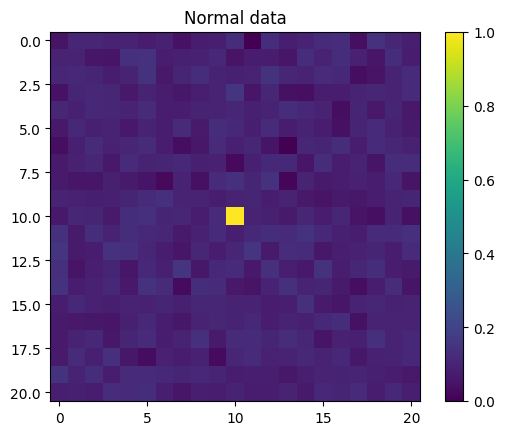

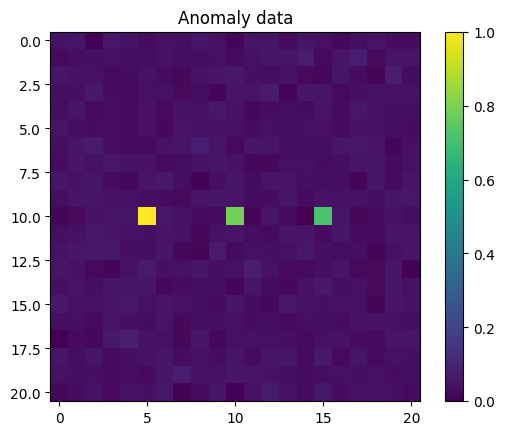

(None, None)

In [152]:
id = 10
print(len(tr_index[id]), weight[id])
plot_data(train_data[id], 'Normal data'), plot_data(train_data[id+NORMAL_DATACOUNT], 'Anomaly data')

In [153]:
train_data[NORMAL_DATACOUNT].shape

(21, 21)

In [154]:
normal_weight = np.array(normal_weight).reshape(NORMAL_DATACOUNT, 1)
weight = list(normal_weight) + weight
position = [[(10, 10)]]*NORMAL_DATACOUNT + position

In [155]:
len(position)

800

In [156]:
type(weight)

list

In [157]:
def generate_cross_mask(shape, center, length):
    """
    십자가 모양의 마스크를 생성한다 (중심에서 멀어질수록 약하게 강조)
    
    Args:
    - shape (tuple): 마스크의 크기 (height, width)
    - center (tuple): 십자가 중심의 (row, col) 위치
    - length (int): 십자가의 팔 길이
    
    Returns:
    - mask (numpy.ndarray): 십자가 모양의 강조 마스크
    """
    height, width = shape
    center_row, center_col = center
    mask = np.zeros((height, width))
    
    for r in range(max(center_row - length, 0), min(center_row + length + 1, height)):
        distance = abs(center_row - r)
        intensity = 1 - (distance / length)
        mask[r, center_col] = intensity
    
    for c in range(max(center_col - length, 0), min(center_col + length + 1, width)):
        distance = abs(center_col - c)
        intensity = 1 - (distance / length)
        mask[center_row, c] = intensity
    
    return mask

def generate_gradcam_labels(input_images, highlight_positions, weight, cross_length=4):
    """
    입력 이미지를 받아 특정 위치에 십자가 모양으로 강조한 이미지를 생성하는 함수.
    
    Args:
    - input_images (numpy.ndarray): (1000, 21, 21) shape의 입력 이미지
    - highlight_positions (list): (1000, 강조할 위치 (row, col))의 리스트
    - cross_length (int): 십자가의 팔 길이
    
    Returns:
    - output_images (numpy.ndarray): 강조된 부분이 있는 이미지들과 동일한 shape
    """
    output_images = input_images.copy()
    height, width = input_images.shape[1], input_images.shape[2]  
    
    for i, img in enumerate(output_images):
        for center, w in zip(highlight_positions[i], weight[i]):
            mask = generate_cross_mask((height, width), center, cross_length)
            img += mask*w*20  # 강조 마스크를 이미지에 추가
    
    tensor_img = torch.tensor(output_images, dtype=torch.float32)
    norm_img = min_max_normalize(tensor_img)
    return norm_img


# GradCAM Label 데이터 생성
gradcam_labels = generate_gradcam_labels(gradcam_data, position, weight, cross_length=4)

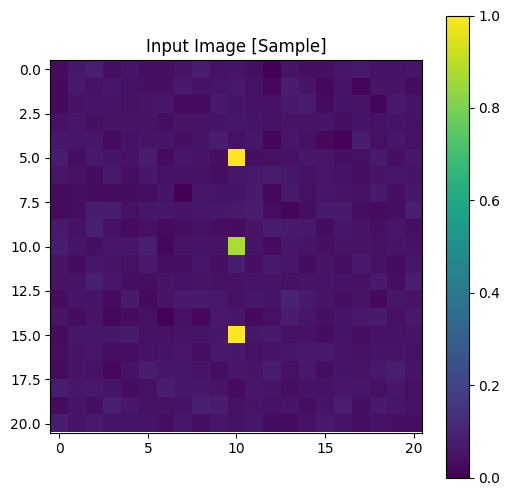

In [158]:
# 첫 번째 이미지 (입력 데이터 중 하나) 시각화
plt.figure(figsize=(6, 6))
plt.imshow(train_data[NORMAL_DATACOUNT+150])
plt.title("Input Image [Sample]")
plt.colorbar()
plt.show()

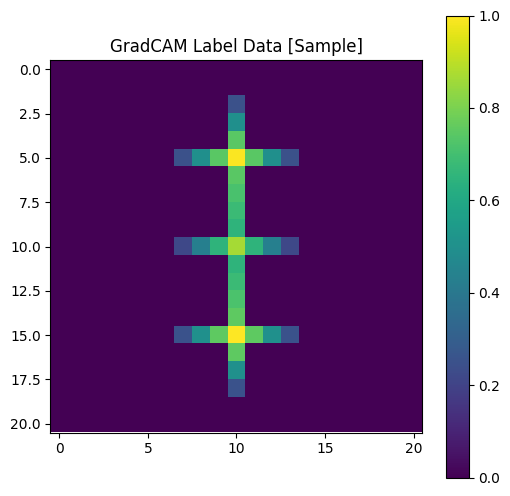

In [159]:
# 첫 번째 이미지 (GradCAM Label 데이터 중 하나) 시각화
plt.figure(figsize=(6, 6))
plt.imshow(gradcam_labels[NORMAL_DATACOUNT+150].numpy())
plt.title("GradCAM Label Data [Sample]")
plt.colorbar()
plt.show()

In [160]:
gradcam_labels = generate_gradcam_labels(gradcam_data, position, weight, cross_length=1)
gradcam_test_labels = generate_gradcam_labels(gradcam_test_data, position, weight, cross_length=1)

gradcam_labels.shape, gradcam_test_labels.shape

(torch.Size([800, 21, 21]), torch.Size([800, 21, 21]))

In [161]:
def make_labels(size):
    l = np.zeros(shape=(size, 2))
    for i in range(0, size//2):
        l[i, 0] = 1
    for j in range(size//2, size):
        l[j, 1] = 1
    return l

train_label = make_labels(TOTAL_DATACOUNT)
test_label = make_labels(TOTAL_DATACOUNT)

train_label = torch.tensor(train_label, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)

train_label, test_label, train_label.shape, test_label.shape

(tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]]),
 tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]]),
 torch.Size([800, 2]),
 torch.Size([800, 2]))

In [162]:
torch.sum(train_label, dim=0)

tensor([400., 400.])

In [163]:
class CustomDataset(Dataset):
    def __init__(self, data, label, gcam_label):
        self.data = data
        self.label = label
        self.gcam_label = gcam_label
        

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0), self.label[idx], self.gcam_label[idx].unsqueeze(0)
        
train_dataset = CustomDataset(train_data, train_label, gradcam_labels)
train_dataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


test_dataset = CustomDataset(test_data, test_label, gradcam_labels)
test_dataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

d, l, gl = next(iter(train_dataLoader))
d.shape, l.shape, gl.shape

(torch.Size([32, 1, 21, 21]), torch.Size([32, 2]), torch.Size([32, 1, 21, 21]))

# GradCAM

In [164]:
class Gradcam(nn.Module):
    def __init__(self):
        super(Gradcam, self).__init__()

        def CBALayer(in_channels, out_channels, kernel_size, stride, padding):
            layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU()
            )
            return layer
        
        self.conv1 = CBALayer(1, 8, 3, 1, 0)
        self.conv2 = CBALayer(8, 16, 3, 1, 0)
        self.conv3 = CBALayer(16, 32, 3, 1, 0)
        
        self.fc1 = nn.Linear(32*15*15, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x.register_hook(self.activations_hook)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x, y, loss_gcam):
        pred_g = self.forward(x)
        loss_g = loss_gcam(pred_g, y)
        loss_g.backward()

        pooled_grad = torch.mean(self.gradients, dim=[2, 3]) # (b, 32, 15, 15) -> (b, 32)     # (neuron importance weight, a)

        x = self.conv1(x)
        x = self.conv2(x)
        activations = self.conv3(x)
        for b in range(activations.size(0)):
            for i in range(activations.size(1)): # 각 feature 마다 weight와 곱하기
                activations[b, i, :, :] *= pooled_grad[b, i]
                
        heatmap = torch.sum(activations, dim=1)
        heatmap = F.relu(heatmap)
    
        # 데이터 정규화
        normalize_heatmap = min_max_normalize(heatmap)
        return normalize_heatmap    

In [165]:
from torchsummary import summary
gcam_model = Gradcam().to(device)
summary(gcam_model, (1, 21, 21), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 19, 19]              80
              ReLU-2            [-1, 8, 19, 19]               0
            Conv2d-3           [-1, 16, 17, 17]           1,168
              ReLU-4           [-1, 16, 17, 17]               0
            Conv2d-5           [-1, 32, 15, 15]           4,640
              ReLU-6           [-1, 32, 15, 15]               0
            Linear-7                  [-1, 100]         720,100
              ReLU-8                  [-1, 100]               0
            Linear-9                    [-1, 2]             202
Total params: 726,190
Trainable params: 726,190
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.77
Estimated Total Size (MB): 3.00
-------------------------------------------

In [166]:
gcam_optimizer = optim.Adam(gcam_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [167]:
# 모델 학습
for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    for tr_x, tr_y, _ in train_dataLoader:
        tr_x = tr_x.to(device)
        tr_y = tr_y.to(device)
                
        pred = gcam_model(tr_x)
        
        loss = criterion(pred, tr_y)

        gcam_optimizer.zero_grad()
        loss.backward()
        gcam_optimizer.step()

        train_loss += loss.item()

        tr_pred = torch.argmax(pred, axis=1)
        tr_label = torch.argmax(tr_y, axis=1)

        tr_pred = tr_pred.detach().cpu().numpy()
        tr_label = tr_label.detach().cpu().numpy()
        correct = sum(tr_pred == tr_label)

        train_acc += correct

    for te_x, te_y, _ in test_dataLoader:
        te_x = te_x.to(device)
        te_y = te_y.to(device)

        outputs = gcam_model(te_x)
        
        loss2 = criterion(outputs, te_y)
        val_loss += loss2.item()

        val_pred = torch.argmax(outputs, axis=1)
        val_label = torch.argmax(te_y, axis=1)

        val_pred = val_pred.detach().cpu().numpy()
        val_label = val_label.detach().cpu().numpy()
        correct2 = sum(val_pred == val_label)

        val_acc += correct2
        
    if (epoch) % 10 == 0:
        print(f'Epoch [{epoch}], Train Loss: {train_loss:.5f}, Train Accuracy : {train_acc/(TOTAL_DATACOUNT):.3f}, \n \
               Val Loss : {val_loss:.3f}, \t Val Accuracy : {val_acc/TOTAL_DATACOUNT:.3f}')
    # if (val_acc/TOTAL_DATACOUNT) >= 0.99 and epoch > 10:
    #     print(f'Epoch [{epoch}], Train Loss: {train_loss:.5f}, Train Accuracy : {train_acc/(TOTAL_DATACOUNT):.3f}, \n \
    #            Val Loss : {val_loss:.3f}, \t Val Accuracy : {val_acc/TOTAL_DATACOUNT:.3f}')
    #     break

Epoch [0], Train Loss: 17.21931, Train Accuracy : 0.547, 
                Val Loss : 16.917, 	 Val Accuracy : 0.598
Epoch [10], Train Loss: 3.30292, Train Accuracy : 0.979, 
                Val Loss : 2.854, 	 Val Accuracy : 0.989
Epoch [20], Train Loss: 0.91390, Train Accuracy : 0.994, 
                Val Loss : 0.762, 	 Val Accuracy : 0.995
Epoch [30], Train Loss: 0.44324, Train Accuracy : 0.995, 
                Val Loss : 0.327, 	 Val Accuracy : 0.996
Epoch [40], Train Loss: 0.31048, Train Accuracy : 0.996, 
                Val Loss : 0.197, 	 Val Accuracy : 1.000


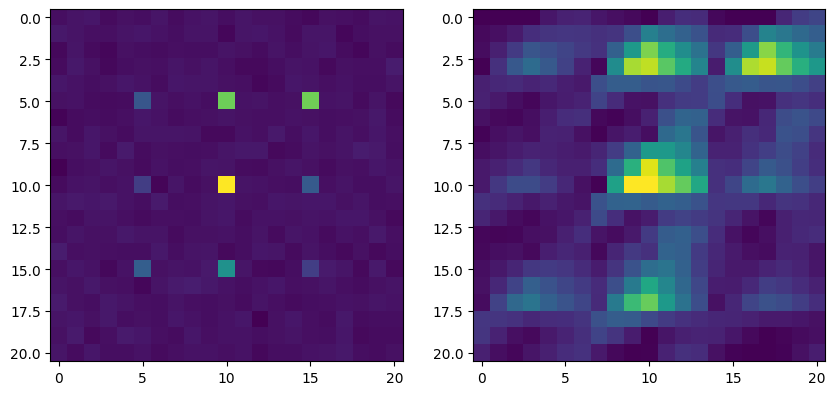

In [168]:
# id = DATACOUNT+(DATACOUNT//4)*3
id = NORMAL_DATACOUNT+300

x, y = torch.tensor(train_data[id], dtype=torch.float32).unsqueeze(0).unsqueeze(0), train_label[id].unsqueeze(0)
# x, y = torch.tensor(test_data[id], dtype=torch.float32).unsqueeze(0).unsqueeze(0), test_label[id].unsqueeze(0)

x = x.to(device)
y = y.to(device)

activations = gcam_model.get_activations(x, y, criterion)

fig = plt.figure(figsize=(10, 6))

fig.add_subplot(1, 2, 1)
plt.imshow(x.squeeze().squeeze().detach().cpu().numpy())

fig.add_subplot(1, 2, 2)
gradcam = F.interpolate(activations.unsqueeze(0), size=(21, 21), mode='bilinear')
plt.imshow(gradcam[0, 0].detach().cpu().numpy())

plt.show()

In [169]:
def evaluate_cams(pred_cams, true_labels, threshold=0.5):
    """
    Evaluates the predicted CAMs against the true labels using Precision, Recall, and F1-score.
    
    Args:
    - pred_cams (torch.Tensor or np.ndarray): Predicted CAMs, shape (batch_size, 21, 21)
    - true_labels (torch.Tensor or np.ndarray): Ground truth labels, shape (batch_size, 21, 21)
    - threshold (float): Threshold to binarize the predicted CAMs

    Returns:
    - precision (float): Precision score
    - recall (float): Recall score
    - f1 (float): F1-score
    """
    # Ensure inputs are numpy arrays
    if isinstance(pred_cams, torch.Tensor):
        pred_cams = pred_cams.detach().cpu().numpy()
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.detach().cpu().numpy()

    # Binarize predicted CAMs based on the threshold
    bin_pred_cams = (pred_cams >= threshold).astype(int)

    # Flatten the arrays
    bin_pred_cams_flat = bin_pred_cams.flatten()
    true_labels_flat = true_labels.flatten()

    # Calculate precision, recall, and F1-score
    precision = precision_score(true_labels_flat, bin_pred_cams_flat, average='binary')
    recall = recall_score(true_labels_flat, bin_pred_cams_flat, average='binary')
    f1 = f1_score(true_labels_flat, bin_pred_cams_flat, average='binary')

    return precision, recall, f1

In [170]:
activations = gcam_model.get_activations(x, y, criterion)

In [171]:
cam_pred = []
cam_true = []
for te_x, te_y, _ in test_dataLoader:
        bin_true_cams = (te_x >= 0.32).type(torch.int16)
        te_x = te_x.to(device)
        te_y = te_y.to(device)

        activations = gcam_model.get_activations(te_x, te_y, criterion)
        gradcam = F.interpolate(activations.unsqueeze(1), size=(21, 21), mode='bilinear')
        # Binarize predicted CAMs based on the threshold

        cam_pred.append(gradcam.detach().cpu().numpy())
        cam_true.append(bin_true_cams.cpu().numpy())

cam_pred = np.concatenate(cam_pred, axis=0)
cam_true = np.concatenate(cam_true, axis=0)

In [172]:
cam_pred.shape, cam_true.shape

((800, 1, 21, 21), (800, 1, 21, 21))

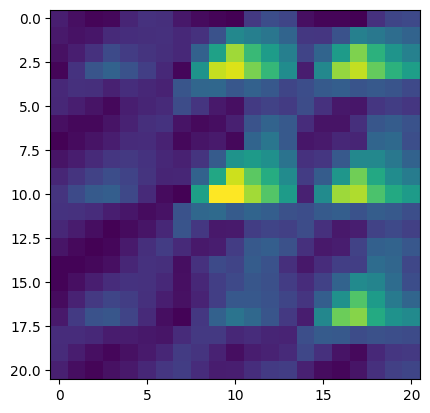

In [173]:
plt.imshow(cam_pred[NORMAL_DATACOUNT][0])

In [174]:
np.sum(cam_true)

2454

In [175]:
precision, recall, f1 = evaluate_cams(cam_pred, cam_true, threshold=0.32)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.0443
Recall: 0.2910
F1-score: 0.0769


# Shapley Value

In [176]:
clear_gpu_cache()

In [177]:
class Shapley(nn.Module):
    def __init__(self):
        super(Shapley, self).__init__()

        def CBALayer(in_channels, out_channels, kernel_size, stride, padding):
            layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU()
            )
            return layer
        
        self.conv1 = CBALayer(1, 8, 3, 1, 0)
        self.conv2 = CBALayer(8, 16, 3, 1, 0)
        self.conv3 = CBALayer(16, 32, 3, 1, 0)
        
        self.fc1 = nn.Linear(32*15*15, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [178]:
from torchsummary import summary
shapley_model = Shapley().to(device)
summary(shapley_model, (1, 21, 21), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 19, 19]              80
              ReLU-2            [-1, 8, 19, 19]               0
            Conv2d-3           [-1, 16, 17, 17]           1,168
              ReLU-4           [-1, 16, 17, 17]               0
            Conv2d-5           [-1, 32, 15, 15]           4,640
              ReLU-6           [-1, 32, 15, 15]               0
            Linear-7                  [-1, 100]         720,100
              ReLU-8                  [-1, 100]               0
            Linear-9                    [-1, 2]             202
Total params: 726,190
Trainable params: 726,190
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.77
Estimated Total Size (MB): 3.00
-------------------------------------------

In [179]:
shapley_optimizer = optim.Adam(shapley_model.parameters(), lr=LR)

In [180]:
train_hist_loss = []
train_hist_acc = []

# 모델 학습
for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for tr_x, tr_y, _ in train_dataLoader:
        tr_x = tr_x.to(device)
        tr_y = tr_y.to(device)
                
        pred = shapley_model(tr_x)
        
        loss = criterion(pred, tr_y)

        shapley_optimizer.zero_grad()
        loss.backward()
        shapley_optimizer.step()

        train_loss += loss.item()

        tr_pred = torch.argmax(pred, axis=1)
        tr_label = torch.argmax(tr_y, axis=1)

        tr_pred = tr_pred.detach().cpu().numpy()
        tr_label = tr_label.detach().cpu().numpy()
        correct = sum(tr_pred == tr_label)

        train_acc += correct

    for te_x, te_y, _ in test_dataLoader:
        te_x = te_x.to(device)
        te_y = te_y.to(device)

        outputs = shapley_model(te_x)
        
        loss2 = criterion(outputs, te_y)
        val_loss += loss2.item()

        val_pred = torch.argmax(outputs, axis=1)
        val_label = torch.argmax(te_y, axis=1)

        val_pred = val_pred.detach().cpu().numpy()
        val_label = val_label.detach().cpu().numpy()
        correct2 = sum(val_pred == val_label)

        val_acc += correct2
        
    if (epoch) % 10 == 0:
        print(f'Epoch [{epoch}], Train Loss: {train_loss:.5f}, Train Accuracy : {train_acc/(TOTAL_DATACOUNT):.3f}, \n \
               Val Loss : {val_loss:.3f}, \t Val Accuracy : {val_acc/TOTAL_DATACOUNT:.3f}')
    # if (val_acc/TOTAL_DATACOUNT) >= 0.99 and epoch > 10:
    #     print(f'Epoch [{epoch}], Train Loss: {train_loss:.5f}, Train Accuracy : {train_acc/(TOTAL_DATACOUNT):.3f}, \n \
    #            Val Loss : {val_loss:.3f}, \t Val Accuracy : {val_acc/TOTAL_DATACOUNT:.3f}')
    #     break

Epoch [0], Train Loss: 17.08624, Train Accuracy : 0.537, 
                Val Loss : 16.824, 	 Val Accuracy : 0.917
Epoch [10], Train Loss: 3.98169, Train Accuracy : 0.975, 
                Val Loss : 3.754, 	 Val Accuracy : 0.989
Epoch [20], Train Loss: 1.13937, Train Accuracy : 0.993, 
                Val Loss : 0.986, 	 Val Accuracy : 0.995
Epoch [30], Train Loss: 0.61976, Train Accuracy : 0.994, 
                Val Loss : 0.464, 	 Val Accuracy : 0.995
Epoch [40], Train Loss: 0.37843, Train Accuracy : 0.996, 
                Val Loss : 0.297, 	 Val Accuracy : 0.996


In [181]:
import shap

def show_attributions(model, td, tl, d):
    # Predict the probabilities of the digits using the test images
    output = model(td.to(device))
    # Get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # Convert to numpy only once to save time
    pred_np = pred.detach().cpu().numpy() 

    expl = shap.DeepExplainer(model, d.to(device))

    shap_values_list = []  # To store SHAP values

    for i in range(0, len(td)):
        ti = td[[i]]            # (batch, channel, height, weight)
        sv = np.array(expl.shap_values(ti))
        shap_values_list.append(sv)  # Store the SHAP values

        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv] # np.swapaxes(, 2, 3)
        tn = np.swapaxes(np.swapaxes(ti.detach().cpu().numpy(), 1, -1), 1, 2)

        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, -tn, show=False)                # shap_values : (class, samples, height, width, channels), images : (samples, height, width, channels)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()
    
        # Show the actual/predicted class
        allaxes[0].set_title('Actual: {}, pred: {}'.format(
            torch.argmax(tl[i]).item(), pred_np[i][0]))
        
        allaxes[1].set_title('Normal')
        allaxes[2].set_title('Anormaly')       

        plt.show()
    
    return expl, shap_values_list

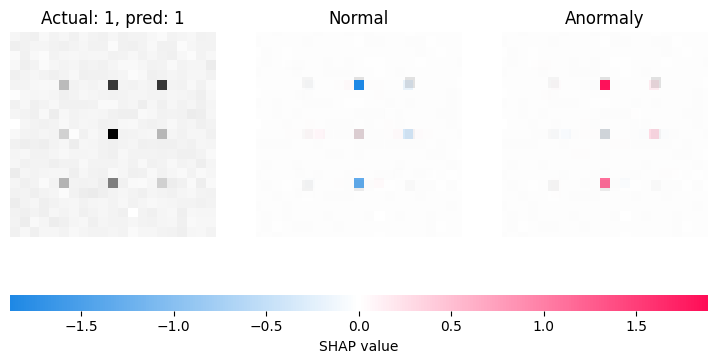

In [182]:
# sv_data, sv_label, _ = next(iter(train_dataLoader))
# d = sv_data[0].unsqueeze(1)
d = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)

explainer, shap_values_list = show_attributions(shapley_model, x, y, d)

In [183]:
# Convert list of SHAP values to a single numpy array
shap_values = np.array(shap_values_list)
shap_values.resize(2, 21, 21)
shap_values.shape

(2, 21, 21)

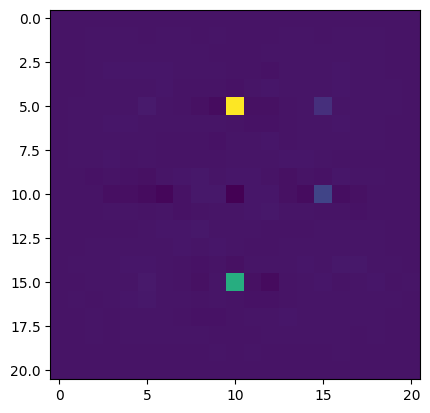

In [184]:
plt.imshow(shap_values[1])
plt.show()

In [185]:
gradcam_labels.shape

torch.Size([800, 21, 21])

In [186]:
cam_pred = []
cam_true = []
for te_x, te_y, _ in test_dataLoader:
        bin_true_cams = (te_x >= 0.32).type(torch.int16)
        te_x = te_x.to(device)
        te_y = te_y.to(device)

        sv = np.array(explainer.shap_values(te_x))     # (class, batch, channel, height, width)
        shap_values = np.array(sv[1])  # Store the SHAP values 
        # shap_values.resize(shap_values.shape[0], 21, 21)
        # Binarize predicted CAMs based on the threshold

        cam_pred.append(shap_values)
        cam_true.append(bin_true_cams.cpu().numpy())

cam_pred = np.concatenate(cam_pred, axis=0)
cam_true = np.concatenate(cam_true, axis=0)

In [187]:
cam_pred = min_max_normalize(cam_pred, False)

In [188]:
plt.imshow(cam_pred[10][0])
plt.colorbar()

In [189]:
# Evaluate metrics
precision, recall, f1 = evaluate_cams(cam_pred, cam_true, threshold=0.32)
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1-score: {f1:.4f}')

In [190]:
for k in range(x.shape[0]):

    print(f"Sample {k}:")
    
    # SHAP 값을 평탄화하고 정렬
    flat_ti = x[k].flatten().detach().cpu().numpy()
    sorted_idx = np.argsort(-np.abs(flat_ti))  # 절대값 기준 내림차순 정렬
    
    # 변화량 기준으로 출력할지 결정
    prev_value = None
    threshold = 10  # 변화량 기준 임계값 설정
    
    for idx in sorted_idx:
        current_value = flat_ti[idx]
        if prev_value is not None:
            if current_value < threshold:
                break  # 변화량이 임계값 이하이면 출력 중단
        
        i, j = divmod(idx.item(), x[k].shape[1])
        print(f"Point ({i},{j}): SHAP value = {current_value}")
        prev_value = current_value

    print()

Sample 0:
Point (10,10): SHAP value = 1.0



In [191]:
for sample_index in range(0, len(x)):
    print(f"Sample {sample_index}:")
    
    ti = x[[sample_index]]
    shap_values = explainer.shap_values(ti)
    sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values] # np.swapaxes(, 2, 3)
    tn = np.swapaxes(np.swapaxes(ti.detach().cpu().numpy(), 1, -1), 1, 2)


    # 현재 샘플의 SHAP 값을 가져옴
    sample_shap_values = sn[1][0, :, :, sample_index]
    
    # SHAP 값을 평탄화하고 정렬
    flat_shap_values = sample_shap_values.flatten()
    sorted_indices = np.argsort(-np.abs(flat_shap_values))  # 절대값 기준 내림차순 정렬
    
    # 변화량 기준으로 출력할지 결정
    prev_value = None
    count = 0  # 변화량 기준 임계값 설정
    
    for idx in sorted_indices:
        current_value = flat_shap_values[idx]
        if prev_value is not None:
            if count >= 5:
                break  # 변화량이 임계값 이하이면 출력 중단
        
        i, j = divmod(idx.item(), sample_shap_values.shape[1])
        print(f"Point ({i},{j}): SHAP value = {current_value}")
        prev_value = current_value
        count += 1

print()


Sample 0:
Point (5,10): SHAP value = 1.8417119979858398
Point (15,10): SHAP value = 1.107380986213684
Point (10,15): SHAP value = 0.29056307673454285
Point (5,15): SHAP value = 0.1536865085363388
Point (10,10): SHAP value = -0.10549415647983551



# Proposed GradCAM

In [192]:
clear_gpu_cache()

In [193]:
# Featured CNN 모델 정의
class Proposed_GradCAM(nn.Module):
    def __init__(self):
        super(Proposed_GradCAM, self).__init__()
        
        self.feature_layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3,1)),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=(3,1)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3,1)),
            nn.ReLU(),
        )

        self.time_layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(1,3)),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=(1,3)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(1,3)),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 21 * 15, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
        self.gradients1 = None
        self.gradients2 = None


    def forward(self, x):
        x1 = self.feature_layer1(x)
        
        x2 = self.time_layer1(x)

        h1 = x1.register_hook(self.activations_hook1)
        h2 = x2.register_hook(self.activations_hook2)

        x2 = x2.permute(0,1,3,2)
        x = torch.concat((x1,x2), dim=1)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def activations_hook1(self,grad):
        self.gradients1 = grad

    def activations_hook2(self,grad):
        self.gradients2 = grad

    def get_activations_gradient1(self):
        return self.gradients1

    def get_activations_gradient2(self):
        return self.gradients2

    def get_activations1(self, x, y, loss_gcam):

        pred_g = self.forward(x)
        loss_g = loss_gcam(pred_g, y)
        loss_g.backward()

        pooled_grad_v1 = torch.mean(self.gradients1, dim=[2, 3]) # (1, 32, 21, 15) -> (32)     # (neuron importance weight, a)

        fx_ac = self.feature_layer1(x)
        new_fx_ac = fx_ac.clone()  # 기존 텐서의 사본을 생성

        for b in range(new_fx_ac.size(0)):  # 각 배치마다
            for i in range(new_fx_ac.size(1)): # 각 feature 마다 weight와 곱하기
                new_fx_ac[b, i, :, :] *= pooled_grad_v1[b, i]
  
        f_heatmap = torch.sum(new_fx_ac, dim=1)
        f_heatmap = F.relu(f_heatmap)
        
        # 데이터 정규화
        normalize_f_heatmap = min_max_normalize(f_heatmap)
        return normalize_f_heatmap
    
    def get_activations2(self, x, y, loss_gcam):
        pred_g = self.forward(x)
        loss_g = loss_gcam(pred_g, y)
        loss_g.backward()

        pooled_grad_v2 = torch.mean(self.gradients2, dim=[2, 3]) # (1, 32, 15, 21) -> (32)     # (neuron importance weight, a)

        tx_ac = self.time_layer1(x)
        new_tx_ac = tx_ac.clone()  # 기존 텐서의 사본을 생성

        for b in range(new_tx_ac.size(0)):  # 각 배치마다
            for i in range(new_tx_ac.size(1)): # 각 feature 마다 weight와 곱하기
                new_tx_ac[b, i, :, :] *= pooled_grad_v2[b, i]
  
        t_heatmap = torch.sum(new_tx_ac, dim=1)
        t_heatmap = F.relu(t_heatmap)
        
        # 데이터 정규화
        normalize_t_heatmap = min_max_normalize(t_heatmap)
        return normalize_t_heatmap
    

    def get_concat_activation(self, x, y, criterion):
        feature_gc = self.get_activations1(x, y, criterion)
        time_gc = self.get_activations2(x, y, criterion)

        time_gc = F.interpolate(time_gc.unsqueeze(1), size=(21, 21), mode='bilinear')
        feature_gc = F.interpolate(feature_gc.unsqueeze(1), size=(21, 21), mode='bilinear')

        concat_gc = min_max_normalize(time_gc+feature_gc)
    
        return concat_gc

In [194]:
from torchsummary import summary
prop_gcam_model = Proposed_GradCAM().to(device)
summary(prop_gcam_model, (1, 21, 21), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 19, 21]              32
              ReLU-2            [-1, 8, 19, 21]               0
            Conv2d-3           [-1, 16, 17, 21]             400
              ReLU-4           [-1, 16, 17, 21]               0
            Conv2d-5           [-1, 32, 15, 21]           1,568
              ReLU-6           [-1, 32, 15, 21]               0
            Conv2d-7            [-1, 8, 21, 19]              32
              ReLU-8            [-1, 8, 21, 19]               0
            Conv2d-9           [-1, 16, 21, 17]             400
             ReLU-10           [-1, 16, 21, 17]               0
           Conv2d-11           [-1, 32, 21, 15]           1,568
             ReLU-12           [-1, 32, 21, 15]               0
           Linear-13                  [-1, 100]       2,016,100
             ReLU-14                  [

In [195]:
criterion_class = nn.CrossEntropyLoss()
criterion_gc = nn.MSELoss()
prop_gcam_optimizer = optim.Adam(prop_gcam_model.parameters(), lr=LR)

In [196]:
alpha = 0.2

In [197]:
train_hist_loss = []
train_hist_acc = []

# 모델 학습
for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for tr_x, tr_y, trgc_y in train_dataLoader:
        tr_x = tr_x.to(device)
        tr_y = tr_y.to(device)
        trgc_y = trgc_y.to(device)
        
        prop_gcam_optimizer.zero_grad()

        pred = prop_gcam_model(tr_x)
        concat_gc = prop_gcam_model.get_concat_activation(tr_x, tr_y, criterion_class)

        loss_class = criterion_class(pred, tr_y)
        loss_gc = criterion_gc(concat_gc, trgc_y)
        loss_total = (alpha * loss_class + (1-alpha)*loss_gc)

        loss_total.backward()
        prop_gcam_optimizer.step()
        
        train_loss += loss_total.item()

        tr_pred = torch.argmax(pred, axis=1)
        tr_label = torch.argmax(tr_y, axis=1)

        tr_pred = tr_pred.detach().cpu().numpy()
        tr_label = tr_label.detach().cpu().numpy()
        correct = sum(tr_pred == tr_label)

        train_acc += correct

    for te_x, te_y, tegc_y in test_dataLoader:
        te_x = te_x.to(device)
        te_y = te_y.to(device)
        tegc_y = tegc_y.to(device)
        
        outputs = prop_gcam_model(te_x)
        
        concat_gc = prop_gcam_model.get_concat_activation(te_x, te_y, criterion_class)
        
        loss_class = criterion_class(outputs, te_y)
        loss_gc = criterion_gc(concat_gc, tegc_y)
        loss_total = (alpha * loss_class + (1-alpha)*loss_gc)

        val_loss += loss_total.item()

        val_pred = torch.argmax(outputs, axis=1)
        val_label = torch.argmax(te_y, axis=1)

        val_pred = val_pred.detach().cpu().numpy()
        val_label = val_label.detach().cpu().numpy()
        correct2 = sum(val_pred == val_label)

        val_acc += correct2
        

    if (epoch) % 2 == 0:
        print(f'Epoch [{epoch}], Train Loss: {train_loss:.5f}, Train Accuracy : {train_acc/(TOTAL_DATACOUNT):.3f}, \n \
               Val Loss : {val_loss:.3f}, \t Val Accuracy : {val_acc/TOTAL_DATACOUNT:.3f}')
    if (val_acc/TOTAL_DATACOUNT) >= 0.97 and epoch > 10:
        print(f'Epoch [{epoch}], Train Loss: {train_loss:.5f}, Train Accuracy : {train_acc/(TOTAL_DATACOUNT):.3f}, \n \
               Val Loss : {val_loss:.3f}, \t Val Accuracy : {val_acc/TOTAL_DATACOUNT:.3f}')
        break

Epoch [0], Train Loss: 4.95031, Train Accuracy : 0.496, 
                Val Loss : 9.354, 	 Val Accuracy : 0.500
Epoch [2], Train Loss: 4.15374, Train Accuracy : 0.545, 
                Val Loss : 5.275, 	 Val Accuracy : 0.510
Epoch [4], Train Loss: 3.54786, Train Accuracy : 0.810, 
                Val Loss : 3.917, 	 Val Accuracy : 0.676
Epoch [6], Train Loss: 3.31562, Train Accuracy : 0.886, 
                Val Loss : 3.255, 	 Val Accuracy : 0.965
Epoch [8], Train Loss: 3.02023, Train Accuracy : 0.806, 
                Val Loss : 2.958, 	 Val Accuracy : 0.920
Epoch [10], Train Loss: 2.78494, Train Accuracy : 0.871, 
                Val Loss : 2.863, 	 Val Accuracy : 0.840
Epoch [12], Train Loss: 2.35576, Train Accuracy : 0.920, 
                Val Loss : 2.328, 	 Val Accuracy : 0.975
Epoch [12], Train Loss: 2.35576, Train Accuracy : 0.920, 
                Val Loss : 2.328, 	 Val Accuracy : 0.975


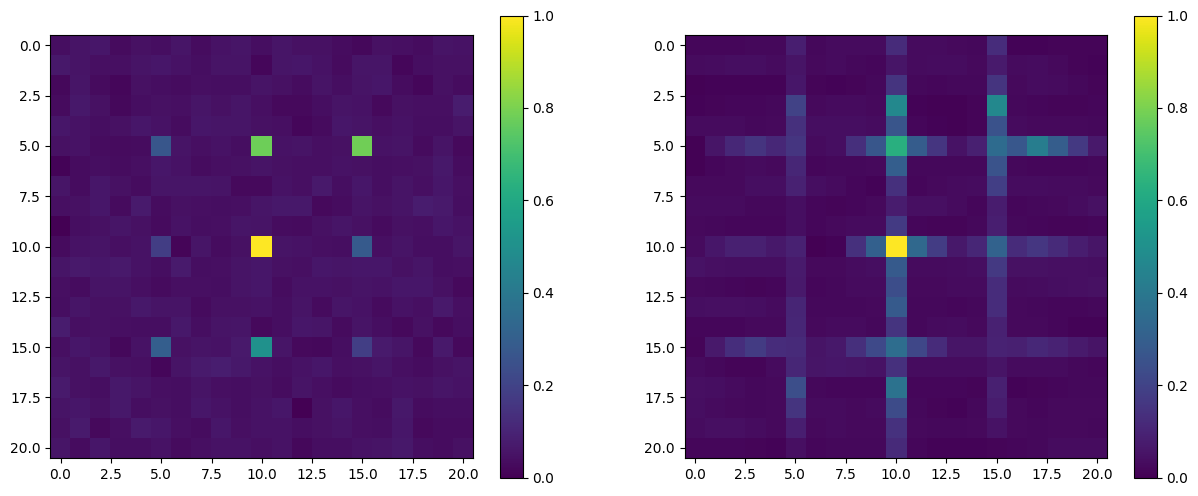

In [198]:
# # id = DATACOUNT+(DATACOUNT//4)*3
# id = NORMAL_DATACOUNT+150

# x, y = torch.tensor(train_data[id], dtype=torch.float32).unsqueeze(0).unsqueeze(0), train_label[id].unsqueeze(0)
# # x, y = torch.tensor(test_data[id], dtype=torch.float32).unsqueeze(0).unsqueeze(0), test_label[id].unsqueeze(0)

# x = x.to(device)
# y = y.to(device)

prop_gradcam = prop_gcam_model.get_concat_activation(x, y, criterion)

fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1, 2, 1)
plt.imshow(x.squeeze().squeeze().detach().cpu().numpy())
plt.colorbar()

fig.add_subplot(1, 2, 2)
plt.imshow(prop_gradcam.squeeze().squeeze().detach().cpu().numpy())
plt.colorbar()
plt.show()

In [ ]:
cam_pred = []
cam_true = []
for te_x, te_y, _ in test_dataLoader:
        bin_true_cams = (te_x >= 0.32).type(torch.int16)
        te_x = te_x.to(device)
        te_y = te_y.to(device)

        activations = prop_gcam_model.get_concat_activation(te_x, te_y, criterion)
        # Binarize predicted CAMs based on the threshold

        cam_pred.append(activations.detach().cpu().numpy())
        cam_true.append(bin_true_cams.cpu().numpy())

cam_pred = np.concatenate(cam_pred, axis=0)
cam_true = np.concatenate(cam_true, axis=0)

In [ ]:
precision, recall, f1 = evaluate_cams(cam_pred, cam_true, threshold=0.32)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.0562
Recall: 0.4109
F1-score: 0.0989


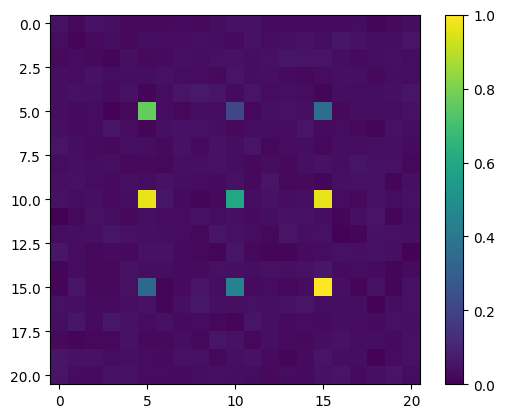

In [ ]:
plt.imshow(x.squeeze().squeeze().detach().cpu().numpy())
plt.colorbar()

In [ ]:
feature_gc = prop_gcam_model.get_activations1(x, y, criterion).squeeze().detach().cpu().numpy()
time_gc = prop_gcam_model.get_activations2(x, y, criterion).squeeze().detach().cpu().numpy()
time_gc.shape, feature_gc.shape

((21, 15), (15, 21))

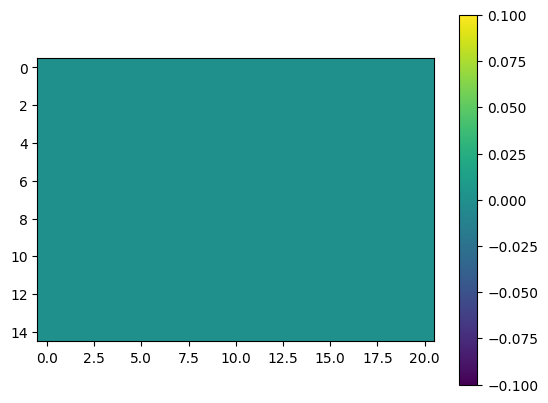

In [ ]:
plt.imshow(feature_gc)
plt.colorbar()
plt.show()

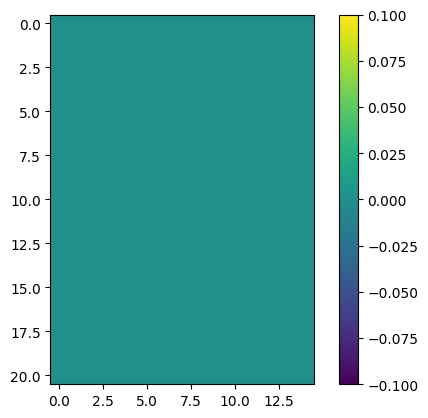

In [ ]:
plt.imshow(time_gc)
plt.colorbar()
plt.show()

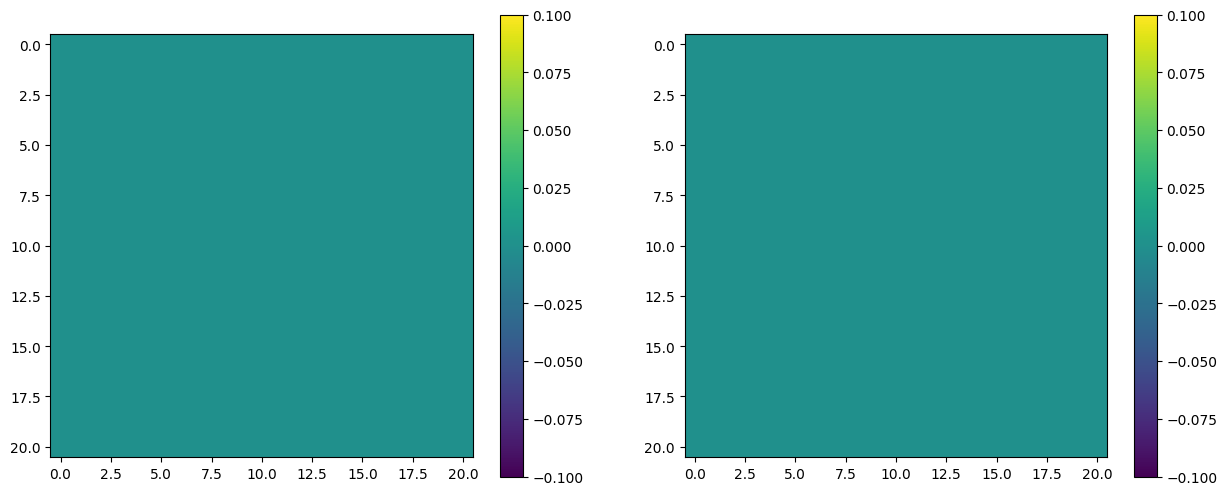

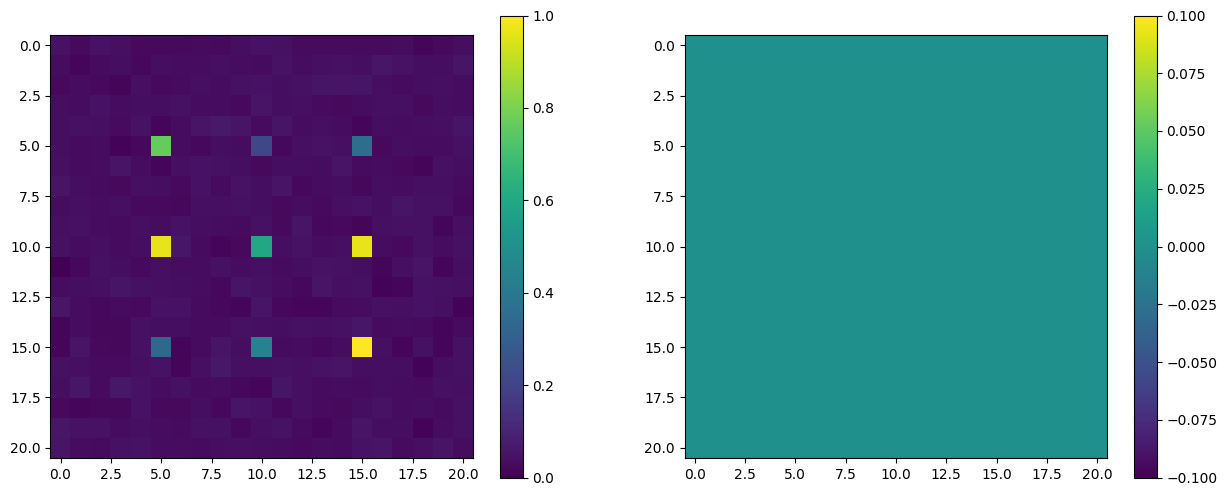

In [ ]:
from PIL import Image

feature_gc = Image.fromarray(feature_gc)
time_gc = Image.fromarray(time_gc)


feature_gc = feature_gc.resize((21, 21), resample=2)
time_gc = time_gc.resize((21, 21), resample=2)

fig = plt.figure(figsize=(15, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(np.array(feature_gc))
plt.colorbar()

fig.add_subplot(1, 2, 2)
plt.imshow(np.array(time_gc))
plt.colorbar()

feature_gc = np.asarray(feature_gc)
time_gc = np.asarray(time_gc)

prop_gradcam = (time_gc+feature_gc)/2


fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1, 2, 1)
plt.imshow(x.squeeze().squeeze().detach().cpu().numpy())
plt.colorbar()

fig.add_subplot(1, 2, 2)
plt.imshow(prop_gradcam)
plt.colorbar()
plt.show()